In [ ]:
SEED = 9126

import os, cv2, json, time, math, sys, pickle, collections
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils import model_zoo

from PIL import Image
import pandas as pd
import numpy as np
np.random.seed(SEED)
import seaborn as sn

#from vmz import models
#import mmaction

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
USE_CUDA = True
CUDA = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print('run on %s' % device)

from google.colab import drive
drive.mount('/content/drive')

run on cuda
Mounted at /content/drive


In [ ]:
# Download and load in memory dataset from kaggle
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
!echo '{"username":"antocommii","key":"87dcebd7c4cb4ba4539ed72f027fcbde"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install -q kaggle #install the kaggle library
!kaggle datasets download --unzip --force antocommii/spacejam-action-recognition -p /content/kaggle/

 97% 605M/626M [00:05<00:00, 134MB/s]
100% 626M/626M [00:05<00:00, 121MB/s]


Data preparation
===

In [ ]:
class CustomSet(torch.utils.data.Dataset):
    def __init__(self, videos_dir, list_dataset, transform):
        """ Construct an indexed list of video paths and labels """
        self.transform = transform
        self.VIDEO_DIR = videos_dir

        self.dataset = list_dataset

    def __getitem__(self, index, is_for_testing=True):
        """ Load video n in the list of image paths and return it along with its label.
            In the case of multiclass the label will probably be a list of values"""
        
        name, label = self.dataset[index]
        fname = os.path.join(self.VIDEO_DIR, name+'.mp4')

        totensor = transforms.ToTensor()

        opf_arr = []
        rgb_arr = []
            
        cap = cv2.VideoCapture(fname)
        ret, frame1 = cap.read()
        frame1 = cv2.resize(frame1, (new_H, new_W))  
        
        # OPT_FLOW
        prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
        hsv = np.zeros_like(frame1)
        hsv[...,1] = 255
            
        # RGB
        frame_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
        frame_rgb = self.transform(Image.fromarray(frame_rgb))
        rgb_arr.append(frame_rgb)
            
        for i in range(1,16):
            ret, frame2 = cap.read()
            frame2 = cv2.resize(frame2, (new_H, new_W))
            # RGB
            frame_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
            frame_rgb = self.transform(Image.fromarray(frame_rgb))
            rgb_arr.append(frame_rgb)
                
            # OPT_FLOW        
            next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
            flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            
            mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
            hsv[...,0] = ang*180/np.pi/2
            hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
            
            opt_rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
            opt_rgb = cv2.cvtColor(opt_rgb,cv2.COLOR_RGB2GRAY)
            opf_arr.append( totensor(opt_rgb) )

            prvs = next

        # SELECT ONE FRAME    
        video = torch.stack(rgb_arr)
        video = torch.transpose(video, 1, 0)

        # OPT_FLOW TO TENSOR
        optflow = torch.stack(opf_arr)
        optflow = torch.squeeze(optflow)
        #optflow = torch.transpose(optflow, 1, 0)
        return {'video':video, 'label':torch.LongTensor([label]), 'opt_flow':optflow}
        

    def __len__(self):
        """ return the total number of video in this dataset """
        return len(self.dataset)

    def get_list(self):
      return self.dataset

In [ ]:
# Definisco nuove dimensioni dei frame dei video
new_H = 224
new_W = 224 
print("New Size: ",new_H,new_W)

# abbiamo 10 classi
num_classes = 10

# il dataset è ciò che si ottiene dal metodo precedente
ROOT_DIR = "/content/kaggle/"
VIDEO_DIR = "/content/kaggle/examples/"
ANNOTATION_FILE = "annotation_dict.json"
TEST_SET_FILE = "testset_keys_1lug2020.txt"

test_transform = transforms.Compose([
                                     transforms.Resize((new_H,new_W)),
                                     #transforms.ColorJitter(hue=.1, brightness=.1, saturation=.1),
                                     transforms.ToTensor(),
                                     #transforms.Normalize(mean=[0.43216,0.394666,0.37645], std=[0.22803,0.22145,0.216989]),
])
train_transform = transforms.Compose([
                                      transforms.Resize((new_H, new_W)),
                                      transforms.ToTensor(),
                                      #transforms.Normalize(mean=[0.43216,0.394666,0.37645], std=[0.22803,0.22145,0.216989]),
])

# prendo il dataset da annotation file
with open(os.path.join(ROOT_DIR, ANNOTATION_FILE)) as fp:
  annotations = json.load(fp)
            
with open(os.path.join(ROOT_DIR, TEST_SET_FILE)) as fp:
  keys_test = json.load(fp)

# RETRIEVE FROM DISK OR CREATE FROM FILES
get_from_disk_sets = False

if(get_from_disk_sets):
  path_save = 'drive/MyDrive/sets/'
  with open(path_save+'train_set','rb') as f:
    train_set=pickle.load(f)
  with open(path_save+'valid_set','rb') as f:
    valid_set=pickle.load(f)
  with open(path_save+'test_set','rb') as f:
    test_set=pickle.load(f)
else:
  # divido in train e test second quello che ho nel file
  annotationTrain = dict(filter(lambda x: x[0] not in keys_test, annotations.items()))
  annotationTest = dict(filter(lambda x: x[0] in keys_test, annotations.items()))
  test_set = list(annotationTest.items())
  # divido in train e validation
  train_set, valid_set = train_test_split(list(annotationTrain.items()), random_state=SEED, test_size=0.1, stratify=list(annotationTrain.values()) )
  path_save = 'drive/MyDrive/sets/'
  with open(path_save+'train_set','wb') as f:
    pickle.dump(train_set, f)
  with open(path_save+'valid_set','wb') as f:
    pickle.dump(valid_set, f)
  with open(path_save+'test_set','wb') as f:
    pickle.dump(test_set, f)

# trasformo in custom_dataset
train_ds = CustomSet(VIDEO_DIR, train_set, train_transform)
valid_ds = CustomSet(VIDEO_DIR, valid_set, test_transform)
test_ds = CustomSet(VIDEO_DIR, test_set, test_transform)

# definisco le batch_size
BATCH_TRAIN_SIZE, BATCH_TEST_SIZE = 4,4

# creo i dataloader
trainLoader = DataLoader(train_ds, batch_size=BATCH_TRAIN_SIZE, shuffle=True)
validLoader = DataLoader(valid_ds, batch_size=BATCH_TEST_SIZE, shuffle=True)
testLoader = DataLoader(test_ds, batch_size=BATCH_TEST_SIZE, shuffle=True)

# controllo se hanno la stessa forma di lista di tuple
print(len(trainLoader), len(validLoader), len(testLoader))
print(train_set[0])

New Size:  224 224
5841 649 2782
('0039141', 6)


walk


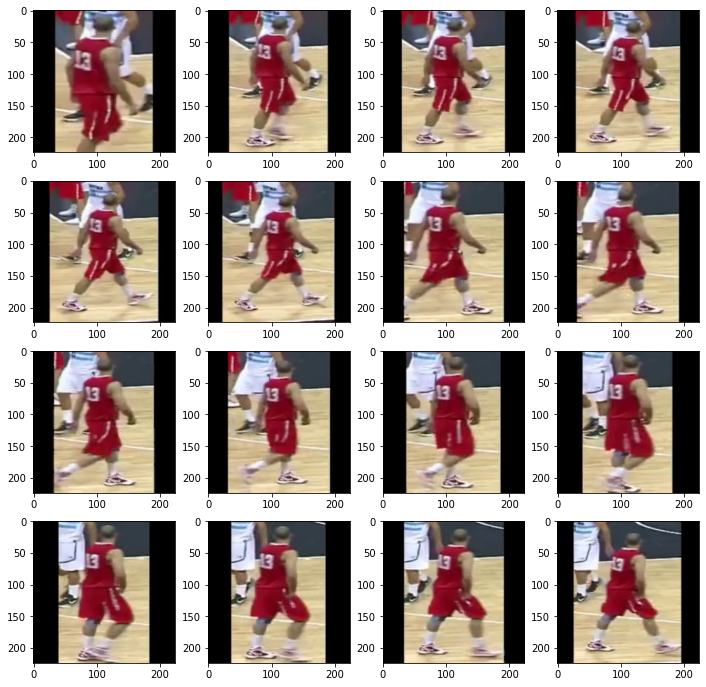

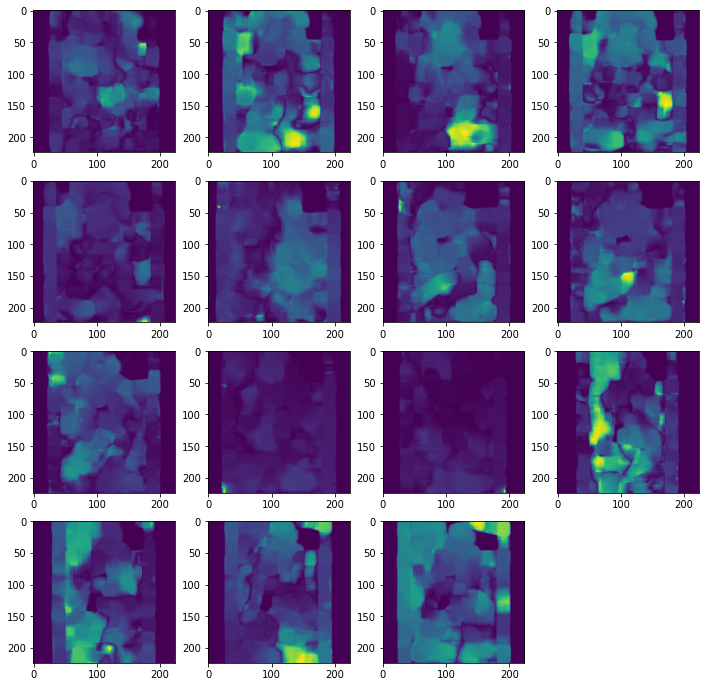

In [ ]:
labels_dict = {0 : "block", 1 : "pass", 2 : "run", 3: "dribble",4: "shoot",
          5 : "ball in hand", 6 : "defense", 7: "pick" , 8 : "no_action" , 
          9: "walk" ,10: "discard"}

for item in trainLoader:
  video = item['video'][0]
  opt_f = item['opt_flow'][0]
  label = item['label'][0]
  break
clip = torch.transpose(video, 0, 1)
flow_clip = opt_f

print(labels_dict[label.item()])

plt.figure(figsize=(12, 12))
for i in range(clip.shape[0]):
  plt.subplot(4,4, i+1)
  video = clip[i]
  trans = transforms.ToPILImage(mode="RGB")
  video = trans(video)
  plt.imshow(video)
plt.show()

plt.figure(figsize=(12, 12))
for i in range(flow_clip.shape[0]):
  plt.subplot(4,4, i+1)
  video = flow_clip[i]
  trans = transforms.ToPILImage()
  video = trans(video)
  plt.imshow(video)
plt.show()

Model
===

Spatial ConvNet
---

In [ ]:
class SpatialConvNet(nn.Module):

  def __init__(self, num_classes=10):
    super(SpatialConvNet, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3,96, kernel_size=7, stride=2),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(96,256, kernel_size=5, stride=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(256,512, kernel_size=3, stride=1),
        nn.ReLU()
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=3, stride=1),
        nn.ReLU()
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.fm_size = 512 * 3 *3

    self.f6 = nn.Sequential(
        nn.Linear(self.fm_size, 4096),
        nn.ReLU(),
        nn.Dropout(p=.5)
    )
    self.f7 = nn.Sequential(
        nn.Linear(4096, 2048),
        nn.ReLU(),
        nn.Dropout(p=.9)
    )
    self.f8 = nn.Linear(2048,num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = x.view(-1, self.fm_size)
    x = self.f6(x)
    x = self.f7(x)
    x = self.f8(x)
    return x

Flow ConvNet
---

In [ ]:
class TemporalConvNet(nn.Module):
  def __init__(self, start_features=15, num_classes=10):
    super(TemporalConvNet, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(start_features, 96, kernel_size=7, stride=2),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(96,256, kernel_size=5, stride=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(256,512, kernel_size=3, stride=1),
        nn.ReLU()
    )
    
    self.conv4 = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=3, stride=1),
        nn.ReLU()
    )
    
    self.conv5 = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.fm_size = 512 * 3 * 3

    self.f6 = nn.Sequential(
        nn.Linear(self.fm_size, 4096),
        nn.ReLU(),
        nn.Dropout(p=.5)
    )

    self.f7 = nn.Sequential(
        nn.Linear(4096, 2048),
        nn.ReLU(),
        nn.Dropout(p=.9)
    )

    self.f8 = nn.Linear(2048,num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = x.view(-1, self.fm_size)
    x = self.f6(x)
    x = self.f7(x)
    x = self.f8(x)
    return x

two stream net
---

https://proceedings.neurips.cc/paper/2014/file/00ec53c4682d36f5c4359f4ae7bd7ba1-Paper.pdf

In [ ]:
model_rgb = SpatialConvNet()
model_flow = TemporalConvNet()

In [ ]:
model_flow

TemporalConvNet(
  (conv1): Sequential(
    (0): Conv2d(15, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (f6): Sequential(
    (0): Linear

In [ ]:
model_rgb

SpatialConvNet(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (f6): Sequential(
    (0): Linear(i

Training
===

In [ ]:
def train_one_epoch(model_rgb, model_flow, optimizer_rgb, optimizer_flow, criterion_rgb, criterion_flow, trainloader, epoch, num_epochs):
    model_rgb.train()
    model_flow.train()
    running_loss = 0.0
    train_correct = 0
  
    for batch_i,item in enumerate(trainloader):
        # GET ITEMS
        opt_flow, target, rgb_video = item['opt_flow'], item['label'], item['video']
        rgb_video = rgb_video[:,:,3]
        target = torch.reshape(target, (-1,))
        opt_flow, target, rgb_video = opt_flow.cuda(), target.cuda(), rgb_video.cuda()
        
        # PREPARE TO TRAIN
        optimizer_rgb.zero_grad()
        optimizer_flow.zero_grad()
        
        # FEED TWO STREAMS
        rgb_outputs = model_rgb(rgb_video)
        flow_outputs = model_flow(opt_flow)
        
        # ESTIMATE LOSS AND BACKPROPAGATE -> RGB
        rgb_loss = criterion_rgb(rgb_outputs, target)
        rgb_loss.backward()
        optimizer_rgb.step()
        
        # ESTIMATE LOSS AND BACKPROPAGATE -> FLOW
        flow_loss = criterion_flow(flow_outputs, target)
        flow_loss.backward()
        optimizer_flow.step()

        # CALCULATE ACCURACIES
        outputs = rgb_outputs + flow_outputs
        _, predicted = torch.max(outputs.data, 1)
        correct_lbls = (predicted == target).sum().item()
        train_correct = train_correct + correct_lbls

        # CALCULATE LOSSES
        running_loss = running_loss + rgb_loss.item() + flow_loss.item()

        # Print log
        sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)] [lr_rgb: %.7f%%] [lr_flow: %.7f%%]"
          % (
            epoch+1,
            num_epochs,
            batch_i,
            len(trainloader),
            rgb_loss.item() + flow_loss.item(),
            running_loss/(1+batch_i),
            100*(correct_lbls/float(BATCH_TRAIN_SIZE)),
            100*(train_correct/float(BATCH_TRAIN_SIZE*(1+batch_i))),
            optimizer_rgb.param_groups[0]['lr'],
            optimizer_flow.param_groups[0]['lr']
          )
        )
    
    return [running_loss, train_correct]


def evaluate(model_rgb, model_flow, criterion_rgb, criterion_flow, validloader, isTestingPhase):
    model_rgb.eval()
    model_flow.eval()

    running_loss = 0.0
    valid_correct = 0
    
    if isTestingPhase:
        predicts, labels = [],[]
  
    with torch.no_grad():
        for item in validloader:
          opt_flow, target, rgb_video = item['opt_flow'], item['label'], item['video']
          rgb_video = rgb_video[:,:,3]
          target = torch.reshape(target, (-1,))
          opt_flow, target, rgb_video = opt_flow.cuda(), target.cuda(), rgb_video.cuda()
            
          # INFERENCE CALCULATING
          rgb_outputs = model_rgb(rgb_video)
          flow_outputs = model_flow(opt_flow)

          # ESTIMATE LOSS
          rgb_loss = criterion_rgb(rgb_outputs, target)
          flow_loss = criterion_flow(flow_outputs, target)
          
          # MONITORING ACCURACY AND LOSS  
          outputs = rgb_outputs + flow_outputs    
          _, predicted = torch.max(outputs.data, 1)
          valid_correct = valid_correct + (predicted == target).sum().item()
          
          running_loss += rgb_loss.item() + flow_loss.item()

          if isTestingPhase:
            predicts.append(predicted.item())
            labels.append(target.item())

    if isTestingPhase:
        return [(predicts, labels), running_loss, valid_correct]
    else:
        return [None, running_loss, valid_correct]

In [ ]:
# SVUOTO LA CACHE
torch.cuda.empty_cache()

# COSTRUISCO OPTIMIZER: learning rate, optimizer e scheluder lr 
lr_rgb, lr_flow = 1e-2, 1e-2
optimizer_rgb = torch.optim.SGD(model_rgb.parameters(),lr=lr_rgb, momentum=0.9) 
optimizer_flow = torch.optim.SGD(model_flow.parameters(),lr=lr_flow, momentum=0.9)
lr_scheduler_rgb = torch.optim.lr_scheduler.StepLR(optimizer_rgb, step_size=5, gamma=0.1) # classico
lr_scheduler_flow = torch.optim.lr_scheduler.StepLR(optimizer_flow, step_size=5, gamma=0.1) # classico

# COSTRUISCO CRITERIO DI LOSS: pesi per ds sbilanciato e criterion
criterion_rgb, criterion_flow = nn.CrossEntropyLoss(), nn.CrossEntropyLoss()

# DEFINISCO PARAMETRI DI TRAINING E VALIDATION
starting_epoch = 0 # numero epoca di partenza
EPOCHS=10
tr_loss, val_loss = [], []
tr_accs, val_accs = [], []

# RECUPERO EPOCHE SALVATE
restore = False
if(restore):
  checkpoint_init = torch.load('drive/MyDrive/_VideoResNet_train_e2.pth')
  starting_epoch = checkpoint_init['epoch'] + 1 
  model.load_state_dict(checkpoint_init['model_state_dict'])
  optimizer.load_state_dict(checkpoint_init['optimizer_state_dict'])
  criterion = checkpoint_init['loss']
  lr_scheduler.load_state_dict(checkpoint_init['scheduler'])
  tr_loss, val_loss = checkpoint_init['losses']
  tr_accs, val_accs = checkpoint_init['accs']

print()
print('(', end="")
print(model_rgb.__class__.__name__, end =" - ")
print(model_flow.__class__.__name__, end =")\n")

# INIZIO ADDESTRAMENTO
model_rgb.cuda()
model_flow.cuda()
for epoch in range(starting_epoch, EPOCHS):
  # TRAIN FOR ONE EPOCH
  start_time = time.time()
  train_loss, train_correct = train_one_epoch(model_rgb, model_flow, optimizer_rgb, optimizer_flow, criterion_rgb, criterion_flow, trainLoader, epoch, EPOCHS)
  
  # VALIDATE RESULT
  _, valid_loss, valid_correct = evaluate(model_rgb, model_flow, criterion_rgb, criterion_flow, validLoader, isTestingPhase=False)

  # STEP TO APPLY LEARNING SCHEDULER
  lr_scheduler_rgb.step()
  lr_scheduler_flow.step() 
  #lr_scheduler.step( valid_loss/float(len(validLoader)) )

  print(
      f' [Val_loss = {valid_loss/float(len(validLoader)):0.7f},'
      f' Val_acc = {100*valid_correct/float(len(validLoader)*BATCH_TEST_SIZE):0.7f}]',
      f'in {time.time()-start_time:.2f} sec'
  )

  tr_loss.append(train_loss/float(len(trainLoader)))
  val_loss.append(valid_loss/float(len(validLoader)))
  tr_accs.append(float(train_correct)/float(len(trainLoader)*BATCH_TRAIN_SIZE))
  val_accs.append(float(valid_correct)/float(len(validLoader)*BATCH_TEST_SIZE))

  checkpoint = {
            'epoch': epoch,
            'model_state_dict_rgb': model_rgb.state_dict(),
            'model_state_dict_flow': model_flow.state_dict(),
            'optimizer_state_dict_rgb': optimizer_rgb.state_dict(),
            'optimizer_state_dict_flow': optimizer_flow.state_dict(),
            'loss_rgb': criterion_rgb,
            'loss_flow': criterion_flow,
            'scheduler_rgb':lr_scheduler_rgb.state_dict(),
            'scheduler_flow':lr_scheduler_flow.state_dict(),
            'losses': (tr_loss, val_loss),
            'accs': (tr_accs, val_accs)
  }

  path="drive/MyDrive/"
  torch.save(checkpoint, path+'TSN_train_e'+str(epoch)+'.pth')


plt.plot(tr_loss, label='Training loss', c='r')
plt.plot(val_loss, label='Validation loss', c='b')
plt.legend(frameon=False)
plt.show()

plt.plot(tr_accs, label='Training accuracy', c='r')
plt.plot(val_accs, label='Validation accuracy', c='b')
plt.legend(frameon=False)
plt.show()


(SpatialConvNet - TemporalConvNet)
[Epoch 1/10] [Batch 314/5841] [Loss: 3.961067 (3.815036), Acc: 0.00% (32.14%)] [lr_rgb: 0.0100000%] [lr_flow: 0.0100000%]